<a href="https://colab.research.google.com/github/tzqu/Efficiency-Cost-Trade-Off-in-Queues-with-Dynamic-Arrivals/blob/main/Linear_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

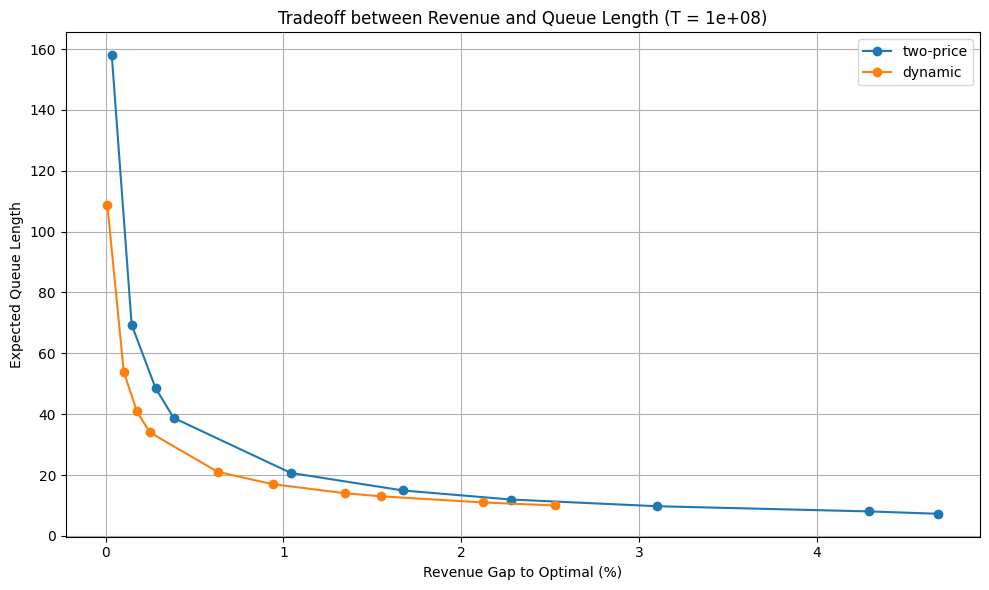

 epsilon    policy  Revenue Gap (%)       E[q]
   0.001 two-price         0.034670 157.959460
   0.001   dynamic         0.009686 108.750655
   0.004 two-price         0.146434  69.391529
   0.004   dynamic         0.102167  53.916445
   0.007 two-price         0.280993  48.536173
   0.007   dynamic         0.175134  40.983115
   0.010 two-price         0.382525  38.769783
   0.010   dynamic         0.248986  33.980191
   0.025 two-price         1.041371  20.692516
   0.025   dynamic         0.632006  20.999740
   0.040 two-price         1.672388  14.921453
   0.040   dynamic         0.939951  16.998505
   0.055 two-price         2.277552  11.955907
   0.055   dynamic         1.347874  13.996633
   0.070 two-price         3.097654   9.753934
   0.070   dynamic         1.550574  12.996862
   0.085 two-price         4.290968   8.040921
   0.085   dynamic         2.119535  10.999331
   0.100 two-price         4.682629   7.259322
   0.100   dynamic         2.524671   9.998762


In [ ]:
# F(x) = 5x - x**2, so p(x) = 5 - x

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
F_dd_1 = -2
mu = 1
max_time = int(1e8)
steady_start = max_time / 2
epsilons = np.array([0.001, 0.004, 0.007, 0.01, 0.025, 0.04, 0.055, 0.07, 0.085, 0.1])

def simulate_policy(epsilon, policy_type):
    np.random.seed(42)
    state = 0
    current_time = 0
    total_revenue = 0
    weighted_q_time = 0
    arrivals = 0

    if policy_type == 'two-price':
        lambda_1 = 1 + np.sqrt(epsilon / -F_dd_1) * np.sqrt(np.log(1 / epsilon))
        lambda_2 = 1 - np.sqrt(epsilon / -F_dd_1) / np.sqrt(np.log(1 / epsilon))
        tau = int(np.floor(0.5 * np.sqrt(-F_dd_1 / epsilon) * np.sqrt(np.log(1 / epsilon))))

        def get_lambda(q):
            return lambda_1 if q < tau else lambda_2

    elif policy_type == 'dynamic':
        B = int(np.floor(np.sqrt(-6 * F_dd_1 / epsilon)))

        def get_lambda(q):
            if q < B:
                return ((q + 2) / (q + 1))**2
            elif q < 2 * B:
                return ((2 * B - q) / (2 * B - q + 1))**2
            else:
                return 0

    def price(lam):
        return 5 - lam

    while current_time < max_time:
        lam = get_lambda(state)
        rate = lam + mu if state > 0 else lam
        if rate == 0:
            break
        dt = np.random.exponential(1 / rate)
        next_time = current_time + dt

        # Decide event type
        if state == 0:
            event_type = 'arrival'
        else:
            event_type = 'arrival' if np.random.rand() < lam / rate else 'service'

        # Revenue and queue tracking during steady-state
        if next_time > steady_start:
            time_contrib = max(0, next_time - max(current_time, steady_start))
            weighted_q_time += state * time_contrib
            if event_type == 'arrival':
                total_revenue += price(lam)
                arrivals += 1

        if event_type == 'arrival':
            state += 1
        elif event_type == 'service' and state > 0:
            state -= 1

        current_time = next_time

    duration = max_time - steady_start
    return total_revenue / duration, weighted_q_time / duration

# Run experiments
data = {'epsilon': [], 'policy': [], 'Revenue Gap (%)': [], 'E[q]': []}
for eps in epsilons:
    for policy in ['two-price', 'dynamic']:
        rev, qlen = simulate_policy(eps, policy)
        gap_percent = (4 - rev) / 4 * 100
        data['epsilon'].append(eps)
        data['policy'].append(policy)
        data['Revenue Gap (%)'].append(gap_percent)
        data['E[q]'].append(qlen)


df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
for policy in ['two-price', 'dynamic']:
    subset = df[df['policy'] == policy]
    plt.plot(subset['Revenue Gap (%)'], subset['E[q]'], marker='o', label=policy)

plt.xlabel("Revenue Gap to Optimal (%)")
plt.ylabel("Expected Queue Length")
plt.title(f"Tradeoff between Revenue and Queue Length (T = {max_time:.0e})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Display DataFrame
print(df.to_string(index=False))

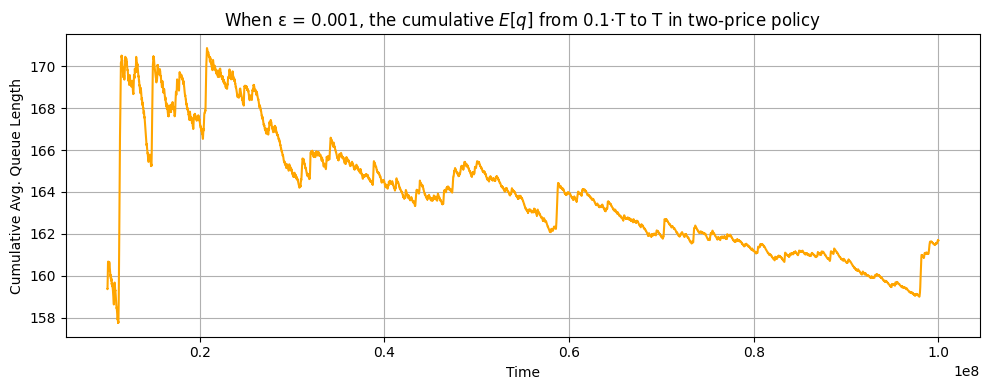

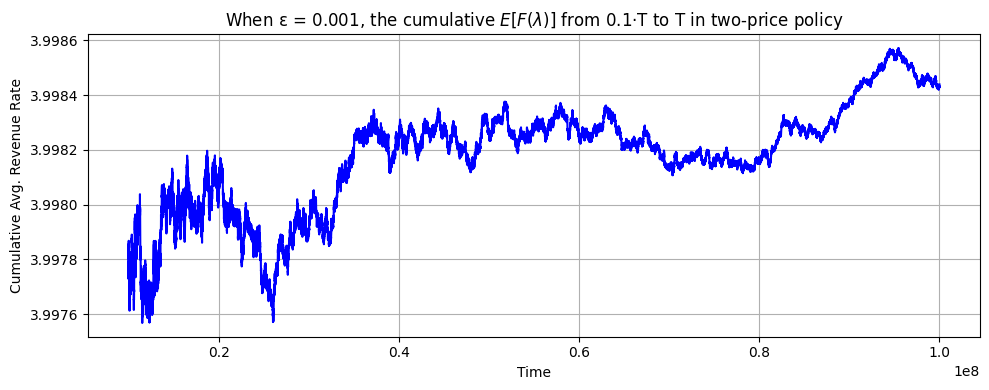

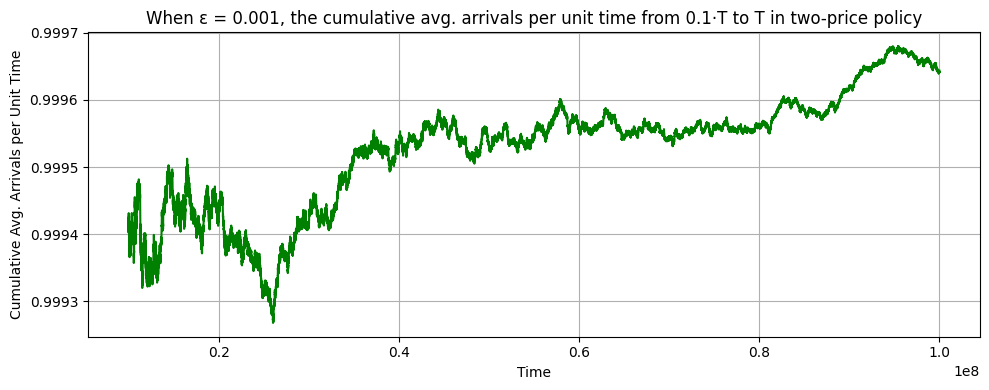

In [ ]:
# F(x) = 5x - x**2, so p(x) = 5 - x

import numpy as np
import matplotlib.pyplot as plt

def simulate_two_price_policy_over_time(epsilon=0.001, max_time=1e8, interval_length=1e3, seed=42):
    np.random.seed(seed)

    F_dd_1 = -2
    mu = 1

    lambda_1 = 1 + np.sqrt(epsilon / -F_dd_1) * np.sqrt(np.log(1 / epsilon))
    lambda_2 = 1 - np.sqrt(epsilon / -F_dd_1) / np.sqrt(np.log(1 / epsilon))

    tau = int(np.floor(0.5 * np.sqrt(-F_dd_1 / epsilon) * np.sqrt(np.log(1 / epsilon))))

    def get_lambda(q):
        return lambda_1 if q < tau else lambda_2

    def get_price(lam):
        return 5 - lam

    state = 0
    current_time = 0

    num_intervals = int(max_time // interval_length)
    time_in_q = np.zeros(num_intervals)
    weighted_q_time = np.zeros(num_intervals)
    revenue_in_interval = np.zeros(num_intervals)
    arrivals_in_interval = np.zeros(num_intervals)

    while current_time < max_time:
        lam = get_lambda(state)
        rate = lam + mu if state > 0 else lam

        if rate == 0:
            break

        dt = np.random.exponential(1 / rate)
        next_time = current_time + dt

        interval_idx = int(current_time // interval_length)
        if interval_idx < num_intervals:
            time_in_q[interval_idx] += dt
            weighted_q_time[interval_idx] += state * dt

        if state == 0:
            event_type = 'arrival'
        else:
            event_type = 'arrival' if np.random.rand() < lam / rate else 'service'

        if event_type == 'arrival':
            state += 1
            arrival_idx = int(next_time // interval_length)
            if arrival_idx < num_intervals:
                revenue_in_interval[arrival_idx] += get_price(lam)
                arrivals_in_interval[arrival_idx] += 1
        elif event_type == 'service' and state > 0:
            state -= 1

        current_time = next_time

    avg_q = weighted_q_time / interval_length
    avg_revenue = revenue_in_interval / interval_length
    avg_arrivals = arrivals_in_interval / interval_length

    time_axis = np.arange(1, num_intervals + 1) * interval_length

    # Compute cumulative averages
    cumulative_avg_q = np.cumsum(avg_q) / np.arange(1, num_intervals + 1)
    cumulative_avg_revenue = np.cumsum(avg_revenue) / np.arange(1, num_intervals + 1)
    cumulative_avg_arrivals = np.cumsum(avg_arrivals) / np.arange(1, num_intervals + 1)

    return time_axis, cumulative_avg_q, cumulative_avg_revenue, cumulative_avg_arrivals, epsilon

# Run simulation
time_pts, cum_q, cum_revenue, cum_arrivals, eps_val = simulate_two_price_policy_over_time()

# Filter: only keep time >= 0.1 * max_time
max_time = time_pts[-1]  # or pass it out from the function if needed
plot_start_time = 0.1 * max_time
mask = time_pts >= plot_start_time

time_pts_filtered = time_pts[mask]
cum_q_filtered = cum_q[mask]
cum_revenue_filtered = cum_revenue[mask]
cum_arrivals_filtered = cum_arrivals[mask]

# Plot cumulative average queue length
plt.figure(figsize=(10, 4))
plt.plot(time_pts_filtered, cum_q_filtered, color='orange')
plt.title(f"When ε = {eps_val}, the cumulative $E[q]$ from 0.1·T to T in two-price policy")
plt.xlabel("Time")
plt.ylabel("Cumulative Avg. Queue Length")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot cumulative average revenue
plt.figure(figsize=(10, 4))
plt.plot(time_pts_filtered, cum_revenue_filtered, color='blue')
plt.title(f"When ε = {eps_val}, the cumulative $E[F(\\lambda)]$ from 0.1·T to T in two-price policy")
plt.xlabel("Time")
plt.ylabel("Cumulative Avg. Revenue Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot cumulative number of arrivals per time
plt.figure(figsize=(10, 4))
plt.plot(time_pts_filtered, cum_arrivals_filtered, color='green')
plt.title(f"When ε = {eps_val}, the cumulative avg. arrivals per unit time from 0.1·T to T in two-price policy")
plt.xlabel("Time")
plt.ylabel("Cumulative Avg. Arrivals per Unit Time")
plt.grid(True)
plt.tight_layout()
plt.show()




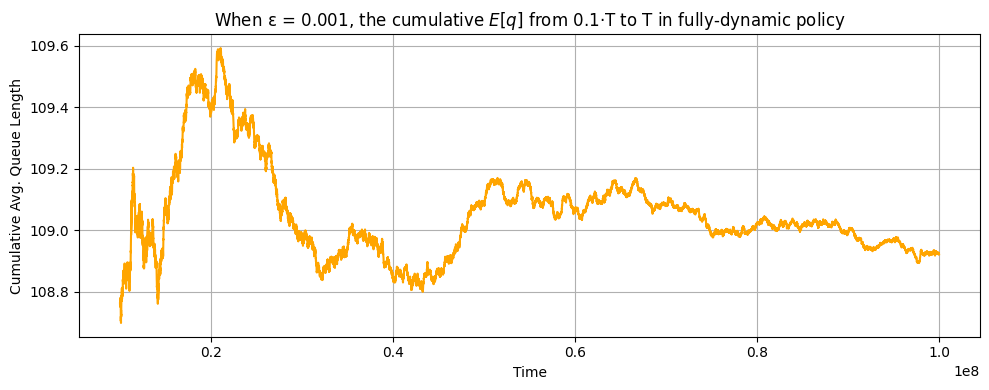

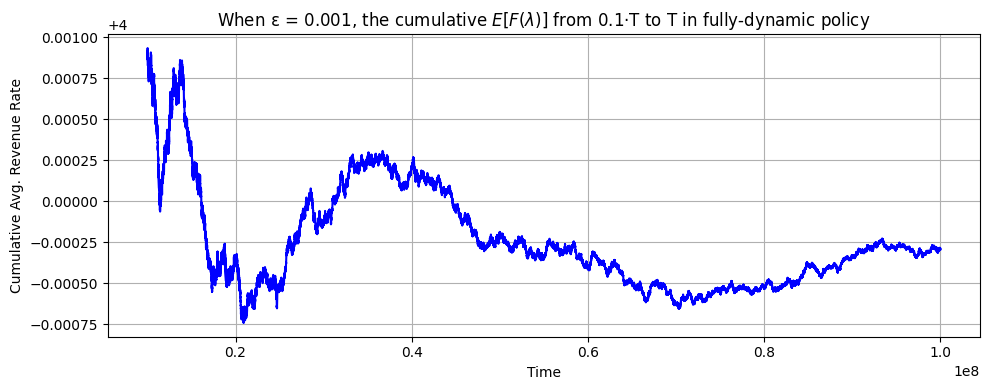

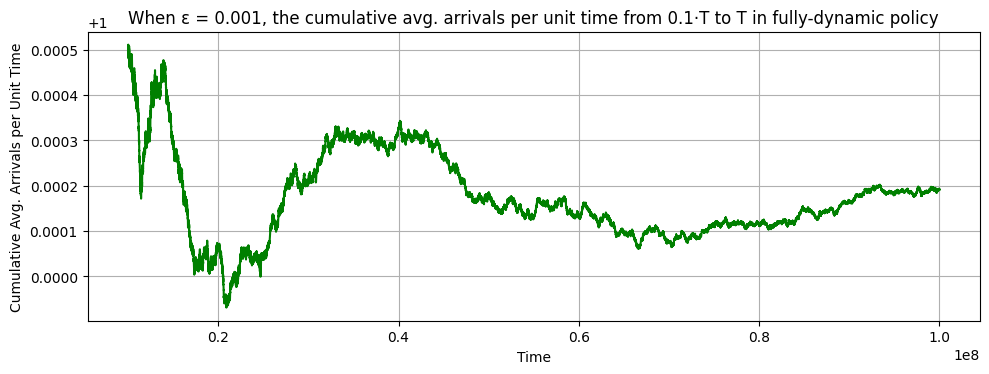

In [ ]:
# F(x) = 5x - x**2, so p(x) = 5 - x

import numpy as np
import matplotlib.pyplot as plt

def simulate_dynamic_policy_over_time(epsilon=0.001, max_time=1e8, interval_length=1e3, seed=42):
    np.random.seed(seed)

    F_dd_1 = -2
    mu = 1

    B = int(np.floor(np.sqrt(-6 * F_dd_1 / epsilon)))  # ensure integer for indexing

    def get_lambda(q):
        if q < B:
          return ((q + 2) / (q + 1))**2
        elif B <= q < 2 * B:
          return ((2 * B - q) / (2 * B - q + 1))**2
        else:
          return 0

    def get_price(lam):
        return 5 - lam

    state = 0
    current_time = 0

    num_intervals = int(max_time // interval_length)
    time_in_q = np.zeros(num_intervals)
    weighted_q_time = np.zeros(num_intervals)
    revenue_in_interval = np.zeros(num_intervals)
    arrivals_in_interval = np.zeros(num_intervals)

    while current_time < max_time:
        lam = get_lambda(state)
        rate = lam + mu if state > 0 else lam

        if rate == 0:
            break

        dt = np.random.exponential(1 / rate)
        next_time = current_time + dt

        interval_idx = int(current_time // interval_length)
        if interval_idx < num_intervals:
            time_in_q[interval_idx] += dt
            weighted_q_time[interval_idx] += state * dt

        if state == 0:
            event_type = 'arrival'
        else:
            event_type = 'arrival' if np.random.rand() < lam / rate else 'service'

        if event_type == 'arrival':
            state += 1
            arrival_idx = int(next_time // interval_length)
            if arrival_idx < num_intervals:
                revenue_in_interval[arrival_idx] += get_price(lam)
                arrivals_in_interval[arrival_idx] += 1
        elif event_type == 'service' and state > 0:
            state -= 1

        current_time = next_time

    avg_q = weighted_q_time / interval_length
    avg_revenue = revenue_in_interval / interval_length
    avg_arrivals = arrivals_in_interval / interval_length

    time_axis = np.arange(1, num_intervals + 1) * interval_length

    # Compute cumulative averages
    cumulative_avg_q = np.cumsum(avg_q) / np.arange(1, num_intervals + 1)
    cumulative_avg_revenue = np.cumsum(avg_revenue) / np.arange(1, num_intervals + 1)
    cumulative_avg_arrivals = np.cumsum(avg_arrivals) / np.arange(1, num_intervals + 1)

    return time_axis, cumulative_avg_q, cumulative_avg_revenue, cumulative_avg_arrivals, epsilon

# Run simulation
time_pts, cum_q, cum_revenue, cum_arrivals, eps_val = simulate_dynamic_policy_over_time()

# Filter: only keep time >= 0.1 * max_time
max_time = time_pts[-1]  # or pass it out from the function if needed
plot_start_time = 0.1 * max_time
mask = time_pts >= plot_start_time

time_pts_filtered = time_pts[mask]
cum_q_filtered = cum_q[mask]
cum_revenue_filtered = cum_revenue[mask]
cum_arrivals_filtered = cum_arrivals[mask]

# Plot cumulative average queue length
plt.figure(figsize=(10, 4))
plt.plot(time_pts_filtered, cum_q_filtered, color='orange')
plt.title(f"When ε = {eps_val}, the cumulative $E[q]$ from 0.1·T to T in fully-dynamic policy")
plt.xlabel("Time")
plt.ylabel("Cumulative Avg. Queue Length")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot cumulative average revenue
plt.figure(figsize=(10, 4))
plt.plot(time_pts_filtered, cum_revenue_filtered, color='blue')
plt.title(f"When ε = {eps_val}, the cumulative $E[F(\\lambda)]$ from 0.1·T to T in fully-dynamic policy")
plt.xlabel("Time")
plt.ylabel("Cumulative Avg. Revenue Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot cumulative number of arrivals per time
plt.figure(figsize=(10, 4))
plt.plot(time_pts_filtered, cum_arrivals_filtered, color='green')
plt.title(f"When ε = {eps_val}, the cumulative avg. arrivals per unit time from 0.1·T to T in fully-dynamic policy")
plt.xlabel("Time")
plt.ylabel("Cumulative Avg. Arrivals per Unit Time")
plt.grid(True)
plt.tight_layout()
plt.show()
